## Dependencies

In [1]:
!pip install -q -U watermark

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
import os
import random
import json
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy
import urllib.request
from urllib.error import HTTPError

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()


## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN, ImageFolder
from torchvision import transforms, models
import torchvision.transforms as T

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from google.colab import drive
from PIL import Image
from IPython.display import display
import cv2
import re

# Import tensorboard
%load_ext tensorboard

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00


<ipython-input-1-6ab84196124f>:31: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy      : 1.23.5
pandas     : 1.5.3
torch      : 2.1.0+cu118
torchvision: 0.16.0+cu118



<Figure size 640x480 with 0 Axes>

##Load Models

In [2]:
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial16"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial16/"
# Files to download
pretrained_files = ["ProtoNet.ckpt", "ProtoMAML.ckpt",
                    "tensorboards/ProtoNet/events.out.tfevents.ProtoNet",
                    "tensorboards/ProtoMAML/events.out.tfevents.ProtoMAML",
                    "protomaml_fewshot.json",
                    "protomaml_svhn_fewshot.json"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Load Dataset

[German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) contains more than 50,000 annotated images of 43 different traffic signs


In [4]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2023-12-07 11:20:35--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  18.5MB/s    in 16s     

2023-12-07 11:20:52 (16.1 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [7]:
main_folder_path = '/content/GTSRB/Final_Training/Images/'

In [8]:
# Check that classes got loaded
files = os.listdir(main_folder_path)
for file in files:
    print(file)

00005
00004
00038
00028
00024
00041
00009
00040
00032
00021
00010
00033
00006
00030
00037
00016
00014
00017
00035
00025
00012
00042
00039
00031
00036
00013
00001
00023
00029
00020
00007
00011
00008
00034
00000
00018
00026
00019
00022
00003
00002
00027
00015


##Preprocessing

In [9]:
# Initialize lists to store images and corresponding labels
images = []
labels = []

# Initialize lists to store one example images and the corresponding labal in two different lists, this is just for plotting
example_images = []
example_labels = []

# Keep track of seen classes in order to store new images in example images
seen_classes = set()

# Specify the desired number of classes
desired_examples = 40
class_names = []

# Loop through all folders and subfolders
for foldername, subfolders, filenames in os.walk(main_folder_path):
  class_names.append(foldername)
  for filename in filenames:
      if filename.endswith('.ppm'):  # adjust the extension based on your image types
          image_path = os.path.join(foldername, filename)

          # Read the image using OpenCV
          img = cv2.imread(image_path)

          # Extract label from the subfolder name (only numeric part)
          label = re.search(r'\d+', os.path.basename(foldername))
          if label:
              label = label.group()

          # Append the image and label to the lists
          images.append(img)
          labels.append(label)

          # Save one images per class as examples
          if label not in seen_classes:
              # Selects one image from this class
              class_indices = [i for i, l in enumerate(labels) if l == label]
              selected_indices = class_indices[:2]

              example_images.extend([images[i] for i in selected_indices])
              example_labels.extend([labels[i] for i in selected_indices])

              seen_classes.add(label)

          # Stop when we have examples for the desired number of classes
          if len(seen_classes) == desired_examples:
              break

# Display the example labels as a sample
print("Example labels:", example_labels)

Example labels: ['00005', '00004', '00038', '00028', '00024', '00041', '00009', '00040', '00032', '00021', '00010', '00033', '00006', '00030', '00037', '00016', '00014', '00017', '00035', '00025', '00012', '00042', '00039', '00031', '00036', '00013', '00001', '00023', '00029', '00020', '00007', '00011', '00008', '00034', '00000', '00018', '00026', '00019', '00022', '00003', '00002', '00027', '00015']


In [10]:
def resize(images):
  # Resize images to a common size (e.g., 32x32) using Pillow
  common_size = (32, 32)
  resized_images = [Image.fromarray(image).resize(common_size, Image.ANTIALIAS) for image in images]

  # Convert resized images to a NumPy array
  images_array = np.stack([np.array(image) for image in resized_images], axis=0)
  return images_array

In [11]:
images = resize(images)
example_images = resize(example_images)

<ipython-input-10-7927ebb537c5>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_images = [Image.fromarray(image).resize(common_size, Image.ANTIALIAS) for image in images]


In [12]:
labels = [int(item) for item in labels]
#converts the images list to np.array to fit with the original notebook
images = np.array(images)
#converts the targets list to tensor to fit with the original notebook
targets = torch.tensor(labels)

###Visualizes 40 out of 43 classes
The last three are left out because python wont let us plot 43 images in a space-efficient and visually appealing way

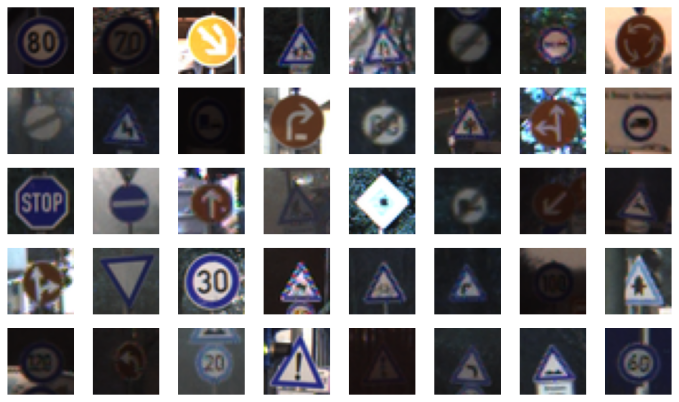

In [13]:
# Display the example images from before
fig, axs = plt.subplots(5, 8, figsize=(12, 7))

for i in range(5):
    for j in range(8):
        index = i * 8 + j
        axs[i, j].imshow(example_images[index])
        axs[i, j].axis('off')

plt.show()

##  Transformations

In [14]:
class ImageDataset(data.Dataset):

    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

In [15]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    class_mask = (targets[:,None] == class_set[None,:]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask],
                        targets=targets[class_mask],
                        **kwargs)

In [16]:
torch.manual_seed(0)           # Set seed for reproducibility
classes = torch.randperm(43)  # Returns random permutation of numbers 0 to 43
train_classes, val_classes, test_classes = classes[:30], classes[31:36], classes[37:43]

In [17]:
# Pre-computed statistics from the new train set
DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(
                                          (32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          DATA_MEANS, DATA_STD)
                                      ])

train_set = dataset_from_labels(
    images, targets, train_classes, img_transform=train_transform)
val_set = dataset_from_labels(
    images, targets, val_classes, img_transform=test_transform)
test_set = dataset_from_labels(
    images, targets, test_classes, img_transform=test_transform)

## Sampling

In [18]:
class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

In [19]:
N_WAY = 3
K_SHOT = 4
train_data_loader = data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True),
                                    num_workers=2)
val_data_loader = data.DataLoader(val_set,
                                  batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False,
                                                                    shuffle_once=True),
                                  num_workers=2)

In [20]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

Lastly, for validation of our data sampling implementation, we can sample a batch and visualize its support and query sets. Our expectation is that the support and query sets should share the same classes while showcasing distinct examples.

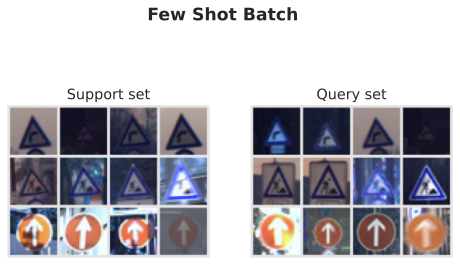

In [21]:
imgs, targets_temp = next(iter(val_data_loader))  # We use the validation set since it does not apply augmentations
support_imgs, query_imgs, _, _ = split_batch(imgs, targets_temp)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()
plt.close()

As observed, the support and query sets consist of the same five classes, featuring distinct examples. The models will be assigned the task of classifying the examples in the query set by leveraging information learned from the support set and its associated labels.

##ProtoNet model

In [22]:
# Make DenseNet
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(growth_rate=32,
                                          block_config=(6, 6, 6, 6),
                                          bn_size=2,
                                          num_init_features=64,
                                          num_classes=output_size  # Output dimensionality
                                         )
    return convnet

In [23]:
class ProtoNet(pl.LightningModule):

    def __init__(self, proto_dim, lr):
        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of Adam optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)

        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        _ = self.calculate_loss(batch, mode="val")

In [64]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(
        CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

In [65]:
protonet_model = train_model(ProtoNet,
                             proto_dim=64,
                             lr=2e-4,
                             train_loader=train_data_loader,
                             val_loader=val_data_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial16/ProtoNet.ckpt`


Found pretrained model at ../saved_models/tutorial16/ProtoNet.ckpt, loading...


In [66]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    """
    Inputs
        model - Pretrained ProtoNet model
        dataset - The dataset on which the test should be performed.
                  Should be instance of ImageDataset
        data_feats - The encoded features of all images in the dataset.
                     If None, they will be newly calculated, and returned
                     for later usage.
        k_shot - Number of examples per class in the support set.
    """
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes  # We assume uniform example distribution here

    # The encoder network remains unchanged across k-shot settings. Hence, we only need
    # to extract the features for all images once.
    if data_feats is None:
        # Dataset preparation
        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        # Select support set and calculate prototypes
        k_img_feats, k_targets = img_features[k_idx:k_idx+k_shot].flatten(0,1), img_targets[k_idx:k_idx+k_shot].flatten(0,1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats, e_targets = img_features[e_idx:e_idx+k_shot].flatten(0,1), img_targets[e_idx:e_idx+k_shot].flatten(0,1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

In [67]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

##ProtoMAML model

In [68]:
class ProtoMAML(pl.LightningModule):

    def __init__(self, proto_dim, lr, lr_inner, lr_output, num_inner_steps):
        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of the outer loop Adam optimizer
            lr_inner - Learning rate of the inner loop SGD optimizer
            lr_output - Learning rate for the output layer in the inner loop
            num_inner_steps - Number of inner loop updates to perform
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140,180], gamma=0.1)
        return [optimizer], [scheduler]

    def run_model(self, local_model, output_weight, output_bias, imgs, labels):
        # Execute a model with given output layer weights and inputs
        feats = local_model(imgs)
        preds = F.linear(feats, output_weight, output_bias)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float()
        return loss, preds, acc

    def adapt_few_shot(self, support_imgs, support_targets):
        # Determine prototype initialization
        support_feats = self.model(support_imgs)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        support_labels = (classes[None,:] == support_targets[:,None]).long().argmax(dim=-1)
        # Create inner-loop model and optimizer
        local_model = deepcopy(self.model)
        local_model.train()
        local_optim = optim.SGD(local_model.parameters(), lr=self.hparams.lr_inner)
        local_optim.zero_grad()
        # Create output layer weights with prototype-based initialization
        init_weight = 2 * prototypes
        init_bias = -torch.norm(prototypes, dim=1)**2
        output_weight = init_weight.detach().requires_grad_()
        output_bias = init_bias.detach().requires_grad_()

        # Optimize inner loop model on support set
        for _ in range(self.hparams.num_inner_steps):
            # Determine loss on the support set
            loss, _, _ = self.run_model(local_model, output_weight, output_bias, support_imgs, support_labels)
            # Calculate gradients and perform inner loop update
            loss.backward()
            local_optim.step()
            # Update output layer via SGD
            # (https://discuss.pytorch.org/t/the-difference-between-torch-tensor-data-and-torch-tensor/25995/4):
            with torch.no_grad():
                output_weight.copy_(output_weight - self.hparams.lr_output * output_weight.grad)
                output_bias.copy_(output_bias - self.hparams.lr_output * output_bias.grad)

            # Reset gradients
            local_optim.zero_grad()
            output_weight.grad.fill_(0)
            output_bias.grad.fill_(0)

        # Re-attach computation graph of prototypes
        output_weight = (output_weight - init_weight).detach() + init_weight
        output_bias = (output_bias - init_bias).detach() + init_bias

        return local_model, output_weight, output_bias, classes

    def outer_loop(self, batch, mode="train"):
        accuracies = []
        losses = []
        self.model.zero_grad()

        # Determine gradients for batch of tasks
        for task_batch in batch:
            imgs, targets = task_batch
            support_imgs, query_imgs, support_targets, query_targets = split_batch(imgs, targets)
            # Perform inner loop adaptation
            local_model, output_weight, output_bias, classes = self.adapt_few_shot(support_imgs, support_targets)
            # Determine loss of query set
            query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
            loss, preds, acc = self.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
            # Calculate gradients for query set loss
            if mode == "train":
                loss.backward()

                for p_global, p_local in zip(self.model.parameters(), local_model.parameters()):
                    p_global.grad += p_local.grad  # First-order approx. -> add gradients of finetuned and base model

            accuracies.append(acc.mean().detach())
            losses.append(loss.detach())

        # Perform update of base model
        if mode == "train":
            opt = self.optimizers()
            opt.step()
            opt.zero_grad()

        self.log(f"{mode}_loss", sum(losses) / len(losses))
        self.log(f"{mode}_acc", sum(accuracies) / len(accuracies))

    def training_step(self, batch, batch_idx):
        self.outer_loop(batch, mode="train")
        return None  # Returning None means we skip the default training optimizer steps by PyTorch Lightning

    def validation_step(self, batch, batch_idx):
        # Validation requires to finetune a model, hence we need to enable gradients
        torch.set_grad_enabled(True)
        self.outer_loop(batch, mode="val")
        torch.set_grad_enabled(False)

In [69]:
class TaskBatchSampler(object):

    def __init__(self, dataset_targets, batch_size, N_way, K_shot, include_query=False, shuffle=True):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            batch_size - Number of tasks to aggregate in a batch
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
        """
        super().__init__()
        self.batch_sampler = FewShotBatchSampler(dataset_targets, N_way, K_shot, include_query, shuffle)
        self.task_batch_size = batch_size
        self.local_batch_size = self.batch_sampler.batch_size

    def __iter__(self):
        # Aggregate multiple batches before returning the indices
        batch_list = []
        for batch_idx, batch in enumerate(self.batch_sampler):
            batch_list.extend(batch)
            if (batch_idx+1) % self.task_batch_size == 0:
                yield batch_list
                batch_list = []

    def __len__(self):
        return len(self.batch_sampler)//self.task_batch_size

    def get_collate_fn(self):
        # Returns a collate function that converts one big tensor into a list of task-specific tensors
        def collate_fn(item_list):
            imgs = torch.stack([img for img, target in item_list], dim=0)
            targets = torch.stack([target for img, target in item_list], dim=0)
            imgs = imgs.chunk(self.task_batch_size, dim=0)
            targets = targets.chunk(self.task_batch_size, dim=0)
            return list(zip(imgs, targets))
        return collate_fn

In [70]:
# Training constant (same as for ProtoNet)
N_WAY = 3
K_SHOT = 4

# Training set
train_protomaml_sampler = TaskBatchSampler(train_set.targets,
                                           include_query=True,
                                           N_way=N_WAY,
                                           K_shot=K_SHOT,
                                           batch_size=16)
train_protomaml_loader = data.DataLoader(train_set,
                                         batch_sampler=train_protomaml_sampler,
                                         collate_fn=train_protomaml_sampler.get_collate_fn(),
                                         num_workers=2)

# Validation set
val_protomaml_sampler = TaskBatchSampler(val_set.targets,
                                         include_query=True,
                                         N_way=N_WAY,
                                         K_shot=K_SHOT,
                                         batch_size=1,  # We do not update the parameters, hence the batch size is irrelevant here
                                         shuffle=False)
val_protomaml_loader = data.DataLoader(val_set,
                                       batch_sampler=val_protomaml_sampler,
                                       collate_fn=val_protomaml_sampler.get_collate_fn(),
                                       num_workers=2)

In [71]:
protomaml_model = train_model(ProtoMAML,
                              proto_dim=64,
                              lr=1e-3,
                              lr_inner=0.1,
                              lr_output=0.1,
                              num_inner_steps=1,
                              train_loader=train_protomaml_loader,
                              val_loader=val_protomaml_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial16/ProtoMAML.ckpt`


Found pretrained model at ../saved_models/tutorial16/ProtoMAML.ckpt, loading...


In [72]:
def test_protomaml(model, dataset, k_shot=4):
    pl.seed_everything(42)
    model = model.to(device)
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes

    # Data loader for full test set as query set
    full_dataloader = data.DataLoader(dataset,
                                      batch_size=128,
                                      num_workers=4,
                                      shuffle=False,
                                      drop_last=False)
    # Data loader for sampling support sets
    sampler = FewShotBatchSampler(dataset.targets,
                                  include_query=False,
                                  N_way=num_classes,
                                  K_shot=k_shot,
                                  shuffle=False,
                                  shuffle_once=False)
    sample_dataloader = data.DataLoader(dataset,
                                        batch_sampler=sampler,
                                        num_workers=2)

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for (support_imgs, support_targets), support_indices in tqdm(zip(sample_dataloader, sampler), "Performing few-shot finetuning"):
        support_imgs = support_imgs.to(device)
        support_targets = support_targets.to(device)
        # Finetune new model on support set
        local_model, output_weight, output_bias, classes = model.adapt_few_shot(support_imgs, support_targets)
        with torch.no_grad():  # No gradients for query set needed
            local_model.eval()
            batch_acc = torch.zeros((0,), dtype=torch.float32, device=device)
            # Evaluate all examples in test dataset
            for query_imgs, query_targets in full_dataloader:
                query_imgs = query_imgs.to(device)
                query_targets = query_targets.to(device)
                query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
                _, _, acc = model.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
                batch_acc = torch.cat([batch_acc, acc.detach()], dim=0)
            # Exclude support set elements
            for s_idx in support_indices:
                batch_acc[s_idx] = 0
            batch_acc = batch_acc.sum().item() / (batch_acc.shape[0] - len(support_indices))
            accuracies.append(batch_acc)
    return mean(accuracies), stdev(accuracies)

In [73]:
protomaml_model.hparams.num_inner_steps = 200

In [74]:
protomaml_result_file = os.path.join(CHECKPOINT_PATH, "protomaml_fewshot.json")

if os.path.isfile(protomaml_result_file):
    # Load pre-computed results
    with open(protomaml_result_file, 'r') as f:
        protomaml_accuracies = json.load(f)
    protomaml_accuracies = {int(k): v for k, v in protomaml_accuracies.items()}
else:
    # Perform same experiments as for ProtoNet
    protomaml_accuracies = dict()
    for k in [2, 4, 8, 16, 32]:
        protomaml_accuracies[k] = test_protomaml(protomaml_model, val_set, k_shot=k)
    # Export results
    with open(protomaml_result_file, 'w') as f:
        json.dump(protomaml_accuracies, f, indent=4)

for k in protomaml_accuracies:
    print(f"Accuracy for k={k}: {100.0*protomaml_accuracies[k][0]:4.2f}% (+-{100.0*protomaml_accuracies[k][1]:4.2f}%)")

Accuracy for k=2: 42.89% (+-3.82%)
Accuracy for k=4: 52.27% (+-2.72%)
Accuracy for k=8: 59.23% (+-1.50%)
Accuracy for k=16: 63.94% (+-1.24%)
Accuracy for k=32: 67.57% (+-0.90%)


In [75]:
import torch
import numpy as np

min_label_count = 200

# Assuming CUB_all_images.data is a memoryview object
imgs = np.array(test_set.imgs)  # Convert to NumPy array
targets = test_set.targets

idxs = np.concatenate([np.where(targets == c)[0][:min_label_count] for c in range(1 + targets.max())], axis=0)
imgs = imgs[idxs.tolist()]  # Convert idxs to a list of integers

# Convert targets to a PyTorch tensor and perform indexing
targets = torch.tensor(targets)[idxs].long()

GTSRB_fewshot_dataset = ImageDataset(imgs, targets, img_transform=test_transform)
print(GTSRB_fewshot_dataset.imgs.shape)

idxs = np.concatenate([np.where(targets==c)[0][:min_label_count] for c in range(1+targets.max())], axis=0)
imgs = imgs[idxs]

GTSRB_fewshot_dataset = ImageDataset(imgs, targets, img_transform=test_transform)
GTSRB_fewshot_dataset.imgs.shape

(1200, 32, 32, 3)


<ipython-input-75-8f6821d1fab4>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)[idxs].long()


(1200, 32, 32, 3)

 ### Printing Accuracies for ProtoNet and ProtoMAML and comparing them in plot further down

In [76]:
protonet_GTSRB_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_GTSRB_accuracies[k], data_feats = test_proto_net(protonet_model, GTSRB_fewshot_dataset, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protonet_GTSRB_accuracies[k][0]:4.2f}% (+-{100*protonet_GTSRB_accuracies[k][1]:4.2f}%)")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Extracting image features:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy for k=2: 53.54% (+-4.60%)


Evaluating prototype classification:   0%|          | 0/50 [00:00<?, ?it/s]

Accuracy for k=4: 59.89% (+-3.85%)


Evaluating prototype classification:   0%|          | 0/25 [00:00<?, ?it/s]

Accuracy for k=8: 64.10% (+-3.39%)


Evaluating prototype classification:   0%|          | 0/13 [00:00<?, ?it/s]

Accuracy for k=16: 73.27% (+-3.90%)


Evaluating prototype classification:   0%|          | 0/7 [00:00<?, ?it/s]

Accuracy for k=32: 84.79% (+-3.41%)


# ProtoMaML

In [ ]:
protomaml_GTSRB_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protomaml_GTSRB_accuracies[k] = test_protomaml(protomaml_model, GTSRB_fewshot_dataset, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protomaml_GTSRB_accuracies[k][0]:4.2f}% (+-{100.0*protomaml_GTSRB_accuracies[k][1]:4.2f}%)")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

NameError: ignored

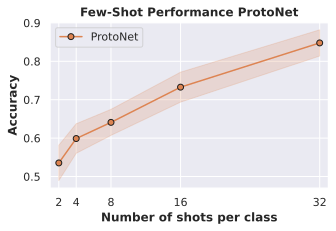

In [77]:
ax = plot_few_shot(protonet_GTSRB_accuracies, name="ProtoNet", color="C1")
plot_few_shot(protomaml_GTSRB_accuracies, name="ProtoMAML", color="C2", ax=ax)
plt.show()
plt.close()

## References

- [ResNet: the intuition behind it](https://wiseodd.github.io/techblog/2016/10/13/residual-net/)
- [Understanding ResNet Intuitively](https://mc.ai/understanding-resnet-intuitively/)
- [Conv Nets: A Modular Perspective](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/)
- [An intuitive guide to Convolutional Neural Networks](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/)
- [A friendly introduction to Convolutional Neural Networks and Image Recognition](https://youtu.be/2-Ol7ZB0MmU?t=721)
- [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](https://arxiv.org/pdf/1610.02136.pdf)
- [How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)
- [Transfer Learning with Convolutional Neural Networks in PyTorch](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce)
- [Image Classification with Transfer Learning and PyTorch](https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/)